### Tworzenie klastrów po zwrotach z inwestcji za pomocą K-MEANS

Klasteryzacja zestawów za pomocą k-means ze względu na roczną stopę zwrotu oraz roczne odchylenie standardowe.

In [1]:
#Importuję biblioteki 

from time import time
import datetime as dt
# from pathlib import Path
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from ipywidgets import IntProgress
# from IPython.display import display

from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

In [8]:
# !pip install tslearn

     -------------------------------------- 374.4/374.4 kB 3.9 MB/s eta 0:00:00


Najpierw pobieram dane z tabelki z cenami.

Porzucam kolumnę `Name`, zmieniam kolumnę `Date` do formatu czasowego i wyliczam `IQR` oraz `Midhinge`.

Pozbywam się danych z ostatniego miesiąca (czerwca 2024).

In [13]:
price_df = pd.read_csv("./data/Brickonomy_Prices_25_06_2024.csv")
price_df = price_df.drop(columns=["Name"])
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df['IQR'] = price_df['Q3'] - price_df['Q1']
price_df['Midhinge'] = 0.5*(price_df['Q3'] + price_df['Q1'])
price_df = price_df[price_df['Date'] < price_df['Date'].max()]

Zrobiłam z poprzedniej tabeli tabelę przestawną, gdzie indeksem jest czas (`Date`), kolumnami są zestawy (`Set_no`) zaś wartościami jest cena (`Midhinge`). Mam zgrabną reprezentację zmian cen zestawów na przestrzeni czasu.

Wtedy każda kolumna jest szeregiem czasowym cen konkretnego zestawu.

Jak widać, niektóre zestawy mają `NaN`-y.

In [14]:
prices_by_set_df = pd.pivot_table(price_df, index='Date', columns='Set_no', values='Midhinge')
prices_by_set_df

Set_no,100 Stores Minifigure,1000-1,10000-1,10002-1,10003-1,10004-1,10006-1,10007-1,10008-1,10009-1,...,San Diego Comic-Con Rocket Raccoon's Warbird,Science Tower,Skyline Express,Steampunk Mini Chess,Tatooine Mini Build,The LEGO Story,Vintage Roadster,White Boba Fett Minifig and Star Wars Character Encyclopedia,Wild West Saloon,Zane
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,NaN,160.535,119.020,219.915,47.035,43.665,29.070,6.845,23.440,6.825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-02-01,NaN,160.590,119.925,221.710,47.450,43.945,29.280,6.850,23.575,6.830,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-03-01,NaN,151.970,114.235,211.280,45.235,41.810,27.880,6.485,22.420,6.465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-01,NaN,161.420,122.200,226.125,48.445,44.675,29.810,6.895,23.945,6.870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-01,NaN,162.230,123.650,228.925,49.070,45.160,30.155,6.930,24.190,6.905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,43.4575,226.475,412.980,646.995,139.835,111.790,78.585,10.530,57.180,9.850,...,521.825,376.465,484.290,235.415,381.565,209.265,218.135,76.570,433.045,11.99
2024-02-01,43.7675,240.220,477.485,686.750,134.535,111.905,78.675,8.200,48.690,10.455,...,395.470,352.160,457.860,198.215,325.990,206.200,195.505,60.220,485.160,13.80
2024-03-01,41.2200,236.555,473.145,552.505,140.855,105.980,76.315,8.955,50.875,10.500,...,432.475,390.035,471.075,201.685,403.765,192.090,225.570,67.895,497.930,11.00


Upewniam się, że wszystkie czasy (miesiące) między pierwszym (min) czasem a ostatnim (max) występują w tabeli.

W tym celu liczę czasy, które powinny być w zakresie (`all_dates_in_range`), a z indeksu pobieram czasy, które są faktycznie (`all_dates_in_index`).

Liczę różnice między oboma zbiorami i wychodzi na to, że jest pusty - czyli w indeksie są wszystkie czasy od min do maxa.

In [15]:
all_dates_in_range = pd.date_range(start=price_df['Date'].min(), end=price_df['Date'].max(), freq='MS').values

In [16]:
all_dates_in_index = prices_by_set_df.index.sort_values().values

In [17]:
np.setdiff1d(all_dates_in_range, all_dates_in_index)

array([], dtype='datetime64[ns]')

Dodatkowo wyliczam tabele zwrotów - `1m`, `3m`, oraz `12m`/`1y`.

W tym celu używam metody `pct_change` z ustawionym odpowiednio argumentem `periods` - dla `1m` jest to `1`, dla `3m` jest to `3`, a dla `1y` jest to `12`.

Pozbywam się pierwszego rzędu, ponieważ jest on cały `NaN`-owy - wynika to z tego, że pierwszy rząd nie ma poprzedniego, aby wyliczyć zmianę procentową.

Ponadto, zamieniam nieskończoności `Inf` na `NaN`-y - będzie łatwiej pracować z tymi tabelami, jak `Inf`-y będą `NaN`-ami.

In [18]:
monthly_returns_by_set_df = prices_by_set_df.pct_change(periods=1).iloc[1:].replace([np.inf, -np.inf], np.nan)
monthly_returns_by_set_df

Set_no,100 Stores Minifigure,1000-1,10000-1,10002-1,10003-1,10004-1,10006-1,10007-1,10008-1,10009-1,...,San Diego Comic-Con Rocket Raccoon's Warbird,Science Tower,Skyline Express,Steampunk Mini Chess,Tatooine Mini Build,The LEGO Story,Vintage Roadster,White Boba Fett Minifig and Star Wars Character Encyclopedia,Wild West Saloon,Zane
Date,,,,,,,,,,,,,,,,,,,,,
2009-02-01,NaN,0.000343,0.007604,0.008162,0.008823,0.006412,0.007224,0.000730,0.005759,0.000733,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-03-01,NaN,-0.053677,-0.047446,-0.047043,-0.046681,-0.048583,-0.047814,-0.053285,-0.048993,-0.053441,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-01,NaN,0.062183,0.069725,0.070262,0.070963,0.068524,0.069225,0.063223,0.068020,0.062645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-01,NaN,0.005018,0.011866,0.012383,0.012901,0.010856,0.011573,0.005076,0.010232,0.005095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-01,NaN,-0.038926,-0.032228,-0.031779,-0.031282,-0.033437,-0.032499,-0.038961,-0.033898,-0.039102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,-0.159673,-0.152493,-0.233569,-0.018790,0.101670,-0.107821,0.202617,0.037438,0.152590,-0.160988,...,0.107544,0.013201,0.017501,-0.156219,-0.194450,-0.143252,0.017516,0.020729,-0.142443,-0.156228
2024-02-01,0.007133,0.060691,0.156194,0.061446,-0.037902,0.001029,0.001145,-0.221273,-0.148478,0.061421,...,-0.242141,-0.064561,-0.054575,-0.158019,-0.145650,-0.014647,-0.103743,-0.213530,0.120345,0.150959
2024-03-01,-0.058205,-0.015257,-0.009089,-0.195479,0.046977,-0.052947,-0.029997,0.092073,0.044876,0.004304,...,0.093572,0.107551,0.028863,0.017506,0.238581,-0.068429,0.153781,0.127449,0.026321,-0.202899


In [19]:
quarterly_returns_by_set_df = prices_by_set_df.pct_change(periods=3).iloc[3:].replace([np.inf, -np.inf], np.nan)
quarterly_returns_by_set_df

Set_no,100 Stores Minifigure,1000-1,10000-1,10002-1,10003-1,10004-1,10006-1,10007-1,10008-1,10009-1,...,San Diego Comic-Con Rocket Raccoon's Warbird,Science Tower,Skyline Express,Steampunk Mini Chess,Tatooine Mini Build,The LEGO Story,Vintage Roadster,White Boba Fett Minifig and Star Wars Character Encyclopedia,Wild West Saloon,Zane
Date,,,,,,,,,,,,,,,,,,,,,
2009-04-01,NaN,0.005513,0.026718,0.028238,0.029978,0.023131,0.025456,0.007305,0.021544,0.006593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-01,NaN,0.010212,0.031061,0.032543,0.034141,0.027648,0.029884,0.011679,0.026087,0.010981,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-01,NaN,0.025959,0.047534,0.049082,0.050846,0.044009,0.046449,0.026985,0.042373,0.026295,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,NaN,0.010377,0.031137,0.032637,0.034266,0.027756,0.030023,0.010877,0.026101,0.010917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-08-01,NaN,0.005609,0.026243,0.027695,0.029244,0.022808,0.025037,0.005772,0.021290,0.006517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,-0.279730,0.008438,-0.080100,0.061805,0.065937,0.012820,0.054549,0.049327,0.043716,-0.059666,...,0.323623,-0.007317,-0.064047,0.148366,-0.265487,-0.025269,0.087033,0.104667,-0.012789,-0.110864
2024-02-01,-0.137799,-0.051563,0.128086,0.327836,-0.092451,-0.056251,0.030924,-0.104803,0.087559,-0.224694,...,-0.197756,-0.010939,-0.019624,-0.212745,-0.336650,-0.203061,0.016720,-0.170238,-0.037629,0.164557
2024-03-01,-0.202939,-0.114772,-0.121911,-0.162090,0.109706,-0.154190,0.167878,-0.117734,0.025499,-0.105622,...,-0.082096,0.049723,-0.010263,-0.277115,-0.147582,-0.213568,0.052197,-0.094914,-0.013951,-0.225897


In [20]:
yearly_returns_by_set_df = prices_by_set_df.pct_change(periods=12).iloc[12:].replace([np.inf, -np.inf], np.nan)
yearly_returns_by_set_df

Set_no,100 Stores Minifigure,1000-1,10000-1,10002-1,10003-1,10004-1,10006-1,10007-1,10008-1,10009-1,...,San Diego Comic-Con Rocket Raccoon's Warbird,Science Tower,Skyline Express,Steampunk Mini Chess,Tatooine Mini Build,The LEGO Story,Vintage Roadster,White Boba Fett Minifig and Star Wars Character Encyclopedia,Wild West Saloon,Zane
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,0.032174,0.118341,0.124616,0.131498,0.103973,0.113519,0.036523,0.097483,0.035165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-01,NaN,0.032038,0.117157,0.123292,0.129926,0.102970,0.112534,0.036496,0.096713,0.035139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-03-01,NaN,0.031980,0.116077,0.122113,0.128883,0.102248,0.111549,0.035466,0.095897,0.035576,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-01,NaN,0.031904,0.114975,0.120907,0.127361,0.101287,0.110533,0.034808,0.095009,0.034934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-01,NaN,0.031838,0.113910,0.119690,0.125943,0.100421,0.109435,0.034632,0.094461,0.035482,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,-0.018298,0.022184,-0.081859,0.163179,0.056475,0.389731,0.029745,0.034889,0.041246,-0.026680,...,-0.027815,0.060136,0.580426,1.088772,-0.201363,-0.090666,0.457440,-0.121198,-0.091692,0.481161
2024-02-01,-0.010009,0.022126,0.238275,0.114185,0.056876,0.255526,0.086296,-0.333333,-0.049951,0.013572,...,-0.198025,0.158154,0.348392,0.587117,-0.308640,-0.066483,0.324829,-0.162390,0.224935,0.538462
2024-03-01,-0.211855,0.022145,0.236076,-0.280794,0.163274,0.042136,0.006595,-0.124205,-0.032243,0.076371,...,-0.009902,0.079816,0.402990,0.302622,-0.215800,-0.069850,0.185744,-0.144414,0.158219,-0.048854


In [300]:
yearly_price_std_by_set_df = prices_by_set_df.rolling(window=12).std().iloc[12:].replace([np.inf, -np.inf], np.nan)
yearly_price_std_by_set_df

Set_no,100 Stores Minifigure,1000-1,10000-1,10002-1,10003-1,10004-1,10006-1,10007-1,10008-1,10009-1,...,San Diego Comic-Con Rocket Raccoon's Warbird,Science Tower,Skyline Express,Steampunk Mini Chess,Tatooine Mini Build,The LEGO Story,Vintage Roadster,White Boba Fett Minifig and Star Wars Character Encyclopedia,Wild West Saloon,Zane
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,9.292126,9.522454,17.977755,3.935242,3.321626,2.286092,0.402612,1.741529,0.401291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-01,NaN,9.254265,9.438587,17.817883,3.899804,3.293826,2.266490,0.400820,1.727338,0.399520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-03-01,NaN,8.767378,8.376894,15.784917,3.448286,2.938350,2.014424,0.377908,1.545384,0.376783,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-01,NaN,8.727124,8.281305,15.600866,3.407377,2.906414,1.991586,0.376099,1.529212,0.374944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-01,NaN,8.707498,8.230414,15.502696,3.385114,2.890145,1.979499,0.375155,1.521011,0.374090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,5.708455,13.037877,51.031460,79.896339,10.425759,8.836303,5.316928,1.165567,4.311230,1.067635,...,44.117273,28.171882,66.670003,49.149835,72.819835,22.713412,31.924618,6.397755,51.852931,1.521086
2024-02-01,5.735902,13.110478,48.545042,80.000010,10.379915,6.429957,5.574973,1.102854,4.387414,1.065706,...,50.229120,21.357511,56.971078,41.634827,83.148538,23.404142,27.302709,7.591650,44.685050,1.296128
2024-03-01,5.849436,13.037431,43.925988,75.937909,10.064315,6.011724,5.597001,1.128254,4.369605,1.036319,...,50.524816,22.045799,41.593219,37.378493,81.878377,24.763100,27.477040,7.500067,40.935243,1.335241


In [104]:
yearly_returns_yearly_std_by_set_df = yearly_returns_by_set_df.rolling(window=12).std().iloc[12:].replace([np.inf, -np.inf], np.nan)
yearly_returns_yearly_std_by_set_df

Set_no,100 Stores Minifigure,1000-1,10000-1,10002-1,10003-1,10004-1,10006-1,10007-1,10008-1,10009-1,...,San Diego Comic-Con Rocket Raccoon's Warbird,Science Tower,Skyline Express,Steampunk Mini Chess,Tatooine Mini Build,The LEGO Story,Vintage Roadster,White Boba Fett Minifig and Star Wars Character Encyclopedia,Wild West Saloon,Zane
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-01,NaN,0.000288,0.003732,0.004115,0.004551,0.002906,0.003483,0.000618,0.002593,0.000550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-01,NaN,0.000294,0.003673,0.004051,0.004484,0.002872,0.003430,0.000574,0.002545,0.000546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-01,NaN,0.000292,0.003601,0.003966,0.004365,0.002813,0.003382,0.000550,0.002483,0.000593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-01,NaN,0.000297,0.003535,0.003885,0.004271,0.002768,0.003300,0.000572,0.002438,0.000639,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-05-01,NaN,0.000291,0.003463,0.003800,0.004164,0.002733,0.003220,0.000568,0.002399,0.000627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,0.115452,0.000146,0.122536,0.221822,0.091029,0.207695,0.186438,0.150816,0.109133,0.110800,...,0.122666,0.131445,0.270012,0.406925,0.232870,0.174396,0.296231,0.265330,0.222645,0.308680
2024-02-01,0.107367,0.000149,0.120608,0.216629,0.091438,0.282332,0.185763,0.142067,0.108425,0.110385,...,0.134597,0.131493,0.257437,0.422908,0.267842,0.181338,0.282170,0.241286,0.207336,0.305551
2024-03-01,0.125947,0.000141,0.125186,0.259358,0.100224,0.361383,0.185104,0.140237,0.108211,0.095701,...,0.132622,0.130826,0.206935,0.482113,0.276978,0.165891,0.288911,0.192309,0.197084,0.333102


In [106]:
yearly_returns_yearly_mean_by_set_df = yearly_returns_by_set_df.rolling(window=12).mean().iloc[12:].replace([np.inf, -np.inf], np.nan)
yearly_returns_yearly_mean_by_set_df

Set_no,100 Stores Minifigure,1000-1,10000-1,10002-1,10003-1,10004-1,10006-1,10007-1,10008-1,10009-1,...,San Diego Comic-Con Rocket Raccoon's Warbird,Science Tower,Skyline Express,Steampunk Mini Chess,Tatooine Mini Build,The LEGO Story,Vintage Roadster,White Boba Fett Minifig and Star Wars Character Encyclopedia,Wild West Saloon,Zane
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-01,NaN,0.031614,0.111345,0.116877,0.122897,0.098499,0.107074,0.035156,0.092645,0.034863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-01,NaN,0.031534,0.110324,0.115749,0.121660,0.097706,0.106112,0.034931,0.091934,0.034822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-01,NaN,0.031454,0.109321,0.114644,0.120417,0.096916,0.105152,0.034892,0.091252,0.034658,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-01,NaN,0.031369,0.108333,0.113554,0.119210,0.096148,0.104223,0.034853,0.090597,0.034560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-05-01,NaN,0.031288,0.107362,0.112489,0.118052,0.095393,0.103323,0.034872,0.089917,0.034400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,0.007279,0.022405,0.082817,0.303618,0.004196,0.922226,0.098238,-0.019094,-0.038078,0.000997,...,0.058084,0.142082,0.440815,1.144842,0.165890,0.105069,0.413010,0.107065,0.224523,0.381825
2024-02-01,0.017298,0.022364,0.081506,0.308357,0.004907,0.878094,0.101628,-0.070925,-0.042412,-0.000755,...,0.025281,0.144114,0.456470,1.132029,0.119503,0.091812,0.431117,0.050442,0.246099,0.410628
2024-03-01,0.001915,0.022326,0.101272,0.238144,0.022535,0.790403,0.102723,-0.067728,-0.043597,0.020944,...,0.029250,0.145234,0.493229,1.085326,0.075983,0.102460,0.421451,-0.006045,0.257725,0.372360


Będzę chciała pracować z zestawami/szeregami, które od wybranego momentu (np. styczeń 2014) nie będą mieć żadnych `NaN`-ów.

W tym celu używam funkcję `get_valid_sets_since_date`, która dokładnie to robi:
- Najpierw filtruje tabelę, aby zostały tylko te rzędy, które są po wybranej dacie;
- Następnie wyrzucamy te kolumny, które mają `NaN`-y (`dropna(axis=1)`);
- Tak przekształconą tabelę zwracam.

In [107]:
def get_valid_sets_since_date(df: pd.DataFrame, cutoff_date: dt.date):
    """
    Ta metoda bierze tabelkę, gdzie kolumnami są szeregi czasowe (zestawy), a indeksem są timestampy.
    Zwraca przefiltrowaną tabelkę, gdzie kolumnami są te szeregi czasowe (zestawy), które po `cutoff_date` nie mają żadnych NaN-ów.
    """
    return df[df.index >= pd.to_datetime(cutoff_date)].dropna(axis=1)

Za pomocą tej metody, można teraz pobrać zestawy, które np. od `2010-01-01` mają zupełne dane i dla nich policzyć korelację w przypadku cen lub zwrotów:

In [108]:
valid_prices_by_set_since_2010_df = get_valid_sets_since_date(prices_by_set_df, dt.date(2010, 1, 1))
# valid_prices_by_set_since_2010_df.corr()

In [109]:
valid_monthly_returns_by_set_since_2010_df = get_valid_sets_since_date(monthly_returns_by_set_df, dt.date(2010, 1, 1))
# valid_monthly_returns_by_set_since_2010_df.corr()

In [110]:
valid_yearly_returns_by_set_since_2010_df = get_valid_sets_since_date(yearly_returns_by_set_df, dt.date(2010, 1, 1))
# valid_yearly_returns_by_set_since_2010_df.corr()

In [151]:
valid_yearly_returns_yearly_std_by_set_df = get_valid_sets_since_date(yearly_returns_yearly_mean_by_set_df, dt.date(2010, 1, 1))

In [152]:
valid_yearly_returns_yearly_mean_by_set_df = get_valid_sets_since_date(yearly_returns_yearly_std_by_set_df, dt.date(2010, 1, 1))

In [303]:
valid_yearly_price_std_by_set_df = get_valid_sets_since_date(yearly_price_std_by_set_df, dt.date(2010, 1, 1))

Szybki rzut okiem sugeruje, że zestaw `1000-1` oraz `10000-1` mają różne korelacje cen i zwrotów - chyba należy dodatkowo wystandardyzować ceny, aby móc miarodajne wyliczyć korelację.

A może jest w tym coś?

In [296]:
# Tworzę model, który klastruje szeregi czasowe

def cluster_timeseries(feature_df_pairs, n_clusters, metric="dtw", max_iter=5):
    n_features = len(feature_df_pairs)
    features = []
    arrs = []
    for feature, feature_df in feature_df_pairs:
        features.append(feature)
        feature_arr = to_time_series_dataset(feature_df.values.transpose())
        arrs.append(feature_arr)
    prepared_arr = np.concatenate(arrs, axis=2)
    t0 = time()
    km_model = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, max_iter=max_iter)
    km_model = km_model.fit(prepared_arr)
    t1 = time()
    print(f'Fitting took {t1 - t0}[s].')
    cluster_centers = km_model.cluster_centers_
    clustered_feature_df_dict = {}
    for n_feature in range(n_features):
        cluster_ts_dict = {}
        for n_cluster in range(n_clusters):
            cluster_ts_dict[f'Cluster {n_cluster}'] = cluster_centers[n_cluster, :, n_feature]
        clustered_feature_df = pd.DataFrame(cluster_ts_dict, index=feature_df_pairs[n_feature][1].index)    
        clustered_feature_df_dict[features[n_feature]] = clustered_feature_df
    labels = km_model.labels_
    return (labels, clustered_feature_df_dict)

In [297]:
# Tworzę funkcję wizualizujacą wyniki

def plot_clusters(clustered_feature_df_dict):
    for feature, df in clustered_feature_df_dict.items():
        df.plot(title=feature)
        plt.show()

In [308]:
# Liczę zestawy, które są w obu klasach szeregów czasowych

common_sets = np.intersect1d(valid_yearly_returns_by_set_since_2010_df.columns, valid_yearly_price_std_by_set_df.columns)
valid_yearly_returns_by_set_since_2010_df = valid_yearly_returns_by_set_since_2010_df[common_sets]
valid_yearly_price_std_by_set_df = valid_yearly_price_std_by_set_df[common_sets]

In [309]:
# Definiuję ilośc klastrów, ilość szeregów i odpalam model
n_clusters = 4
feature_df_pairs = [("Yearly returns", valid_yearly_returns_by_set_since_2010_df), ("Yearly price std", valid_yearly_price_std_by_set_df)]
(labels, clustered_feature_df_dict) = cluster_timeseries(feature_df_pairs, n_clusters)

Fitting took 205.79620170593262[s].


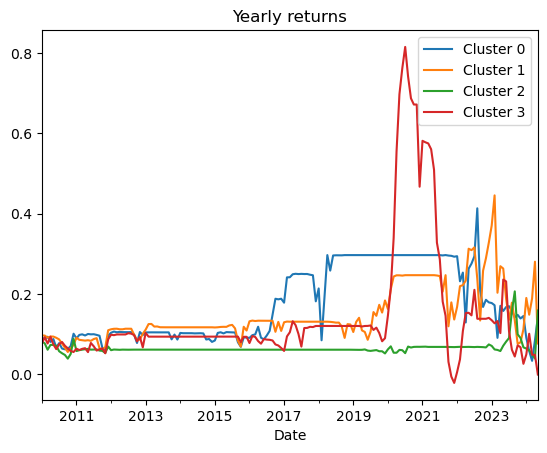

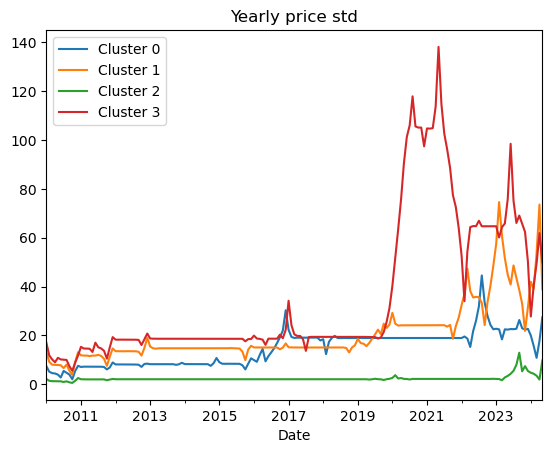

In [310]:
plot_clusters(clustered_feature_df_dict)

Jak widać mamy 4 wyraźne rodzaje zestawów:

    - Zielony (Low risk - low yield)  - niski zwrot, niskie ryzyko
    - Czerwony (High risk - high yield) - wysoki zwrot, wysokie ryzyko
    - Niebieski (High yield - low risk) - wysoki zwrot, niskie ryzyko
    - Pomarańczowy (low yield - high risk) - niski zwrot, wysokie ryzyko